In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

read predictions on test and train with best xgboost, lightgbm an catboost models

In [2]:
predontest_xgb =  pd.read_csv('submissions/xgbm.csv')
predontest_lgb =  pd.read_csv('submissions/lgbm.csv')
predontest_catb =  pd.read_csv('submissions/catboost.csv')

In [3]:
predontest_xgb

,ID,item_cnt_month
0,0,0.588261
1,1,0.296947
2,2,1.587208
3,3,0.738030
4,4,3.253019
...,...,...
214195,214195,0.135754
214196,214196,0.074607
214197,214197,0.015581
214198,214198,0.060094


create dataframe X_test

In [4]:
X_test = pd.DataFrame({'xgb':predontest_xgb['item_cnt_month'].values, 'lgb':predontest_lgb['item_cnt_month'].values, 'catb':predontest_catb['item_cnt_month'].values})


In [5]:
X_test

,xgb,lgb,catb
0,0.588261,0.718470,0.429158
1,0.296947,0.226456,0.168294
2,1.587208,1.033477,0.829892
3,0.738030,0.426672,0.328639
4,3.253019,3.000036,0.739699
...,...,...,...
214195,0.135754,0.172739,0.232274
214196,0.074607,0.048725,0.141065
214197,0.015581,0.041025,0.119414
214198,0.060094,0.081854,0.114678


In [6]:
predontrain_xgb =  pd.read_csv('data/predontrain_xgb.csv')
predontrain_lgb =  pd.read_csv('data/predontrain_lgb.csv')
predontrain_catb =  pd.read_csv('data/predontrain_catb.csv')

create dataframe train_ens for ensemble

In [7]:
train_ens = pd.concat([predontrain_xgb, predontrain_lgb, predontrain_catb], axis=1)


In [36]:
train = pd.read_csv('data/train_numfeatures.csv.gz') 
train = train[train['date_block_num']>11] 

In [37]:
train_ens['target'] = train['target'].values
train_ens['date_block_num'] = train['date_block_num'].values

In [38]:
train_ens

,xgb,lgb,catb,target,date_block_num
0,0.015573,0.044819,0.134381,0.0,12
1,0.232097,0.255670,0.317225,0.0,12
2,0.119659,0.118585,0.182601,0.0,12
3,0.234045,0.410999,0.433735,1.0,12
4,0.619276,0.657736,0.584820,1.0,12
...,...,...,...,...,...
6425089,0.162137,0.150535,0.162200,0.0,33
6425090,0.126034,0.112086,0.142501,0.0,33
6425091,0.146326,0.146969,0.146095,0.0,33
6425092,0.000000,0.038277,0.114424,0.0,33


check if train_ens is created in a correct way (we check if rmse is the same we calculated in notebooks for modeling)

In [39]:
print('rmse xgb:', np.sqrt(mean_squared_error(train_ens['xgb'],train_ens['target'])))

rmse xgb: 0.8357605253145622


In [40]:
print('rmse lgb:', np.sqrt(mean_squared_error(train_ens['lgb'],train_ens['target'])))

rmse lgb: 0.8385849195301215


In [41]:
print('rmse catb:', np.sqrt(mean_squared_error(train_ens['catb'],train_ens['target'])))

rmse catb: 0.9126242564699992


train_ens is created in a correct way
<p>let's check correlation between predictions and target

In [14]:
train_ens.drop('date_block_num', axis=1).corr()

,xgb,lgb,catb,target
xgb,1.000000,0.980970,0.935921,0.710263
lgb,0.980970,1.000000,0.952725,0.708429
catb,0.935921,0.952725,1.000000,0.662519
target,0.710263,0.708429,0.662519,1.000000


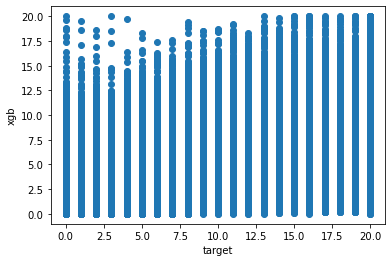

In [15]:
plt.xlabel('target')
plt.ylabel('xgb')
plt.scatter(train_ens['target'], train_ens['xgb']);

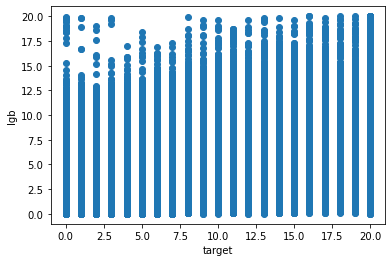

In [12]:
plt.xlabel('target')
plt.ylabel('lgb')
plt.scatter(train_ens['target'], train_ens['lgb']);

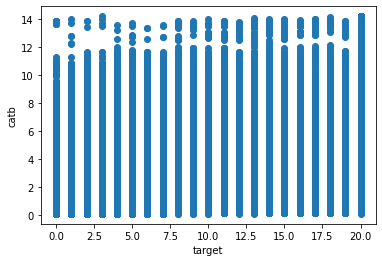

In [13]:
plt.xlabel('target')
plt.ylabel('catb')
plt.scatter(train_ens['target'], train_ens['catb']);

correlation of predictions with best xgboost, lightgbm an catboost models is rather high (> 0.94), so we don't expect much improvement from ensemble. let's build an ensemble and check

In [42]:
# trainv_ens and valid_ens
trainv_ens = train_ens[train_ens['date_block_num']!=33]
valid_ens = train_ens[train_ens['date_block_num']==33]

X_train = trainv_ens.drop(['target', 'date_block_num'], axis=1)
y_train = trainv_ens['target']
X_valid = valid_ens.drop(['target', 'date_block_num'], axis=1)
y_valid = valid_ens['target']

In [43]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(n_jobs=-1)
lr.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': -1,
 'normalize': False,
 'positive': False}

In [44]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train).clip(min=0, max=20)
print('RMSE on train: ', np.sqrt(mean_squared_error(y_train_pred, y_train)))
y_valid_pred = lr.predict(X_valid).clip(min=0, max=20)
print('RMSE on valid: ', np.sqrt(mean_squared_error(y_valid_pred, y_valid)))


RMSE on train:  0.7777478726609164
RMSE on valid:  0.8959955011798524


In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [22]:
def linear_model(polinom_degree, lin_estimator, X_train, y_train, X_valid, y_valid):
    print('degree:',polinom_degree)
    poly_model = make_pipeline(PolynomialFeatures(polinom_degree), lin_estimator)
    poly_model.fit(X_train, y_train)
    y_train_pred = poly_model.predict(X_train).clip(min=0, max=20)
    print('RMSE on train: ', np.sqrt(mean_squared_error(y_train_pred, y_train)))
    y_valid_pred = poly_model.predict(X_valid).clip(min=0, max=20)
    print('RMSE on valid: ', np.sqrt(mean_squared_error(y_valid_pred, y_valid)))

In [45]:
lin_estimator = LinearRegression()
print('linear estimator:',lin_estimator)
degree = np.arange(1, 4)
for d in degree:
    linear_model(d, lin_estimator, X_train, y_train, X_valid, y_valid)

linear estimator: LinearRegression()
degree: 1
RMSE on train:  0.7777478726609004
RMSE on valid:  0.8959955011798604
degree: 2
RMSE on train:  0.772713804180416
RMSE on valid:  0.8856274122888874
degree: 3
RMSE on train:  0.7688197697388985
RMSE on valid:  0.8764723160801469


In [24]:
%%time
X_train = train_ens.drop(['target', 'date_block_num'], axis=1)
y_train = train_ens['target']
best_ens = make_pipeline(PolynomialFeatures(2), LinearRegression())
best_ens.fit(X_train, y_train)
y_train_pred = best_ens.predict(X_train).clip(min=0, max=20)
print('RMSE on train: ', np.sqrt(mean_squared_error(y_train_pred, y_train)))

RMSE on train:  0.8218900111139738
CPU times: user 4.42 s, sys: 974 ms, total: 5.4 s
Wall time: 2.01 s


In [25]:
test_id = predontest_xgb['ID']
y_pred = best_ens.predict(X_test).clip(min=0, max=20)
pd.DataFrame({'ID': test_id, 'item_cnt_month': y_pred}).to_csv("submissions/ensemble_lr.csv", index=False)

RMSE on test on private/public leaderboard is 0.9349/0.9305

In [26]:
import lightgbm as lgb

In [27]:
X_train = trainv_ens.drop(['target', 'date_block_num'], axis=1)
y_train = trainv_ens['target']
X_valid = valid_ens.drop(['target', 'date_block_num'], axis=1)
y_valid = valid_ens['target']

[5]	training's rmse: 0.973753	valid_0's rmse: 0.975321
[10]	training's rmse: 0.884542	valid_0's rmse: 0.910829
[15]	training's rmse: 0.849302	valid_0's rmse: 0.888163
[20]	training's rmse: 0.835336	valid_0's rmse: 0.878549
[25]	training's rmse: 0.829228	valid_0's rmse: 0.874586
[30]	training's rmse: 0.826052	valid_0's rmse: 0.870371
[35]	training's rmse: 0.824223	valid_0's rmse: 0.868107
[40]	training's rmse: 0.822899	valid_0's rmse: 0.866794
[45]	training's rmse: 0.821879	valid_0's rmse: 0.866023
[50]	training's rmse: 0.821049	valid_0's rmse: 0.864835
[55]	training's rmse: 0.820166	valid_0's rmse: 0.863908
[60]	training's rmse: 0.819549	valid_0's rmse: 0.863676
[65]	training's rmse: 0.818875	valid_0's rmse: 0.863262
[70]	training's rmse: 0.818398	valid_0's rmse: 0.86312
[75]	training's rmse: 0.817902	valid_0's rmse: 0.862998
[80]	training's rmse: 0.817457	valid_0's rmse: 0.863013
[85]	training's rmse: 0.817134	valid_0's rmse: 0.863237
[90]	training's rmse: 0.816604	valid_0's rmse: 0.8

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

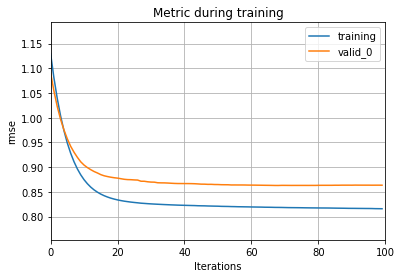

In [28]:
%%time
# Scikit-learn API (LGBMRegressor) is chosen as it's easier to build validation plot (in comparison with Training API)

model = lgb.LGBMRegressor(objective='rmse', n_estimators=100)
model.fit(X_train,
          y_train, 
          eval_set=[(X_valid, y_valid),(X_train,y_train)], 
          verbose=5  
        )

lgb.plot_metric(model);

In [29]:
%%time
X_train = train_ens.drop(['target', 'date_block_num'], axis=1)
y_train = train_ens['target']


best_ens_lgb = lgb.LGBMRegressor(objective='rmse', n_estimators=50)
best_ens_lgb.fit(X_train,
          y_train, 
          eval_set=[(X_train,y_train)],
          verbose=5  
        )

[5]	training's rmse: 0.974304
[10]	training's rmse: 0.886107
[15]	training's rmse: 0.851495
[20]	training's rmse: 0.837421
[25]	training's rmse: 0.831372
[30]	training's rmse: 0.828416
[35]	training's rmse: 0.826683
[40]	training's rmse: 0.825487
[45]	training's rmse: 0.824651
[50]	training's rmse: 0.823666
CPU times: user 22.1 s, sys: 2.18 s, total: 24.3 s
Wall time: 3.95 s


LGBMRegressor(n_estimators=50, objective='rmse')

In [31]:
test_id = predontest_xgb['ID']
y_pred = best_ens_lgb.predict(X_test).clip(min=0, max=20)
pd.DataFrame({'ID': test_id, 'item_cnt_month': y_pred}).to_csv("submissions/ensemble_lgb.csv", index=False)


RMSE on test on private/public leaderboard is 0.9704/0.9637 

<p>Conclusion: the best of obtained so far models is ensemble on 3 models (xgboost, lightgbm and catboost), metalener is linear regression with polynomial features (degree=2). RMSE on test for this model is 0.9349/0.9305 on private/public leaderboard.
<p>Further improvement of the solution:
    <ul>
            <li>make preprocessing (stemming, stop words removal etc.) and tf-idf and/or word-to-vec encoding for text variables (shop_name, item_name, item_category_name), use obtained features in modeling;
            <li>build xgboost, lightgbm and catboost on different groups of features, stack built models.